# Forecasting Airline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
data = pd.read_excel('Airlines+Data.xlsx')
data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [3]:
data.isna().sum().sum()

0

In [4]:
data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [5]:
data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


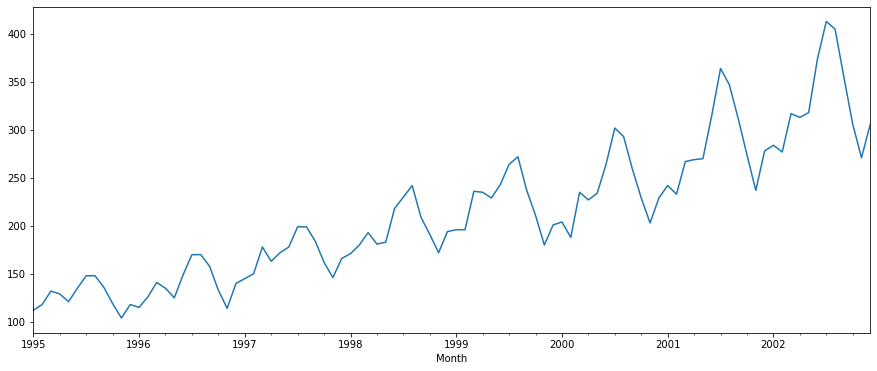

In [7]:
data['Passengers'].plot(figsize=(15, 6))
plt.show()

<AxesSubplot:>

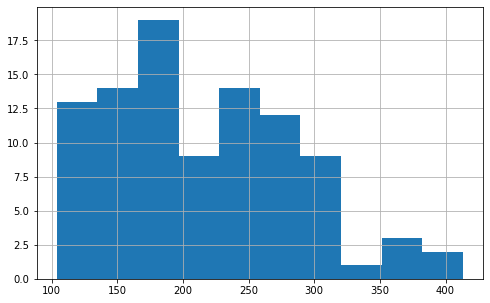

In [8]:
# Histogram
ax = plt.axes()
data['Passengers'].hist(figsize=(8,5))

<AxesSubplot:ylabel='Density'>

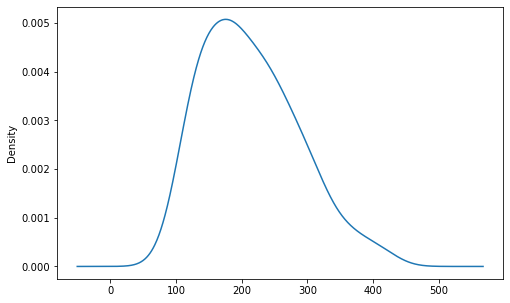

In [9]:
# Density Plot

data['Passengers'].plot(kind = 'kde', figsize=(8,5))

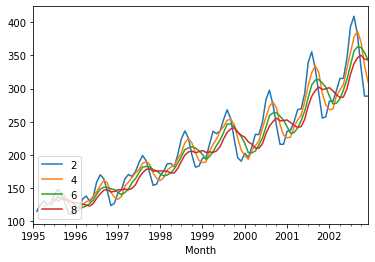

In [10]:
for i in range(2,10,2):
    data['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)


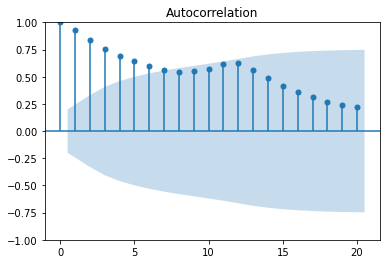

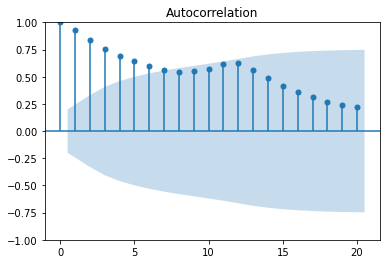

In [11]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data['Passengers'])

# Comparing Multiple Models

## Data Driven Forecasting Methods

In [81]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [82]:
# Splitting data into Train and Test (77/33)
Train = data.head(84)
Test = data.tail(12)

### Moving Average Method

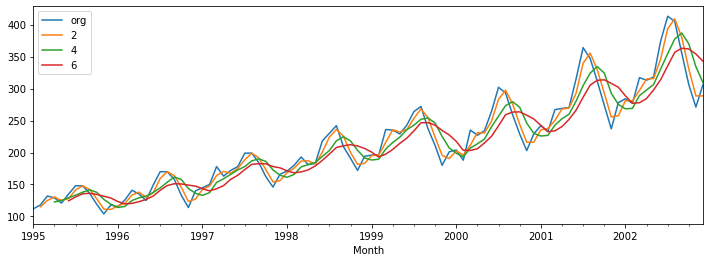

In [83]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,8,2):
    data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

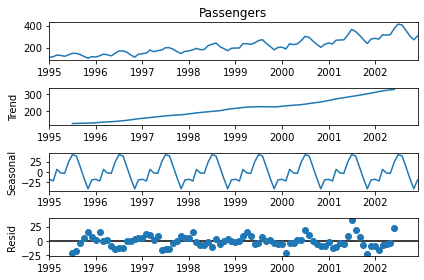

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

### Evaluation Metric RMSE

In [86]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

### Simple Exponential Method

In [88]:
warnings.filterwarnings("ignore")

In [89]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model = RMSE(Test.Passengers, pred_ses)
rmse_ses_model

68.00674031349644

### Holt method

In [90]:
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Passengers, pred_hw)
rmse_hw_model

58.57384693071804

### Holts winter exponential smoothing with additive seasonality and additive trend

In [91]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add_model

62.71208217570936

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [92]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Passengers, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

64.66373828300254

## Model based Forecasting Methods

In [93]:
# Data preprocessing for models
data1 = data.copy()
data1.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [94]:
data1["t"] = np.arange(1,97)
data1["t_squared"] = data1["t"]*data1["t"]

data1["log_psngr"] = np.log(data1["Passengers"])

data1.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791


In [95]:
# Splitting data into Train and Test (77/33)
Train = data1.head(84)
Test = data1.tail(12)

### Linear Model

In [96]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

53.199236534802715

### Exponential Model

In [97]:
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

46.0573611031562

### Quadratic Model

In [98]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

48.051888979330975

### Build Model based on the optimized values


In [100]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model]]


In [101]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,68.006740
1,Holt method,58.573847
2,HW exp smoothing add,62.712082
3,HW exp smoothing mult,64.663738
4,Linear Mode,53.199237
5,Exp model,46.057361
6,Quad model,48.051889
